# Library Preparation

In [ ]:
!pip install -q torchmetrics onnx

In [ ]:
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassAccuracy
import torchvision.transforms.functional as TF
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

import matplotlib.pyplot as plt

import os
import shutil
import random
import numpy as np
from tqdm import tqdm

# Initialization Directory of Dataset

## Check if directory has already exists and extracted

In [ ]:
if os.path.exists('split_rice_leaf_dataset'):
  shutil.rmtree('split_rice_leaf_dataset')
  print("Removed split dataset")

if os.path.exists('rice_leaf_dataset.zip'):
  os.remove('rice_leaf_dataset.zip')
  print("Removed file dataset")

## Get data from github

In [ ]:
!wget -q https://github.com/meinhere/semantic-segformer/raw/main/rice_leaf_dataset.zip
!unzip -q -u "/content/rice_leaf_dataset.zip"

## Distribution of dataset

In [ ]:
base_dir = 'rice_leaf_dataset'
image_dir = os.path.join(base_dir, 'images')
mask_dir = os.path.join(base_dir, 'mask')

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

print(f"Number of image files: {len(image_files)}")
print(f"Number of mask files: {len(mask_files)}")

Number of image files: 1991
Number of mask files: 1991


## Directory Preparation

### Make pair data images and mask

In [ ]:
data_pairs = [(os.path.join(image_dir, img), os.path.join(mask_dir, mask)) for img, mask in zip(image_files, mask_files)]
print(f"Number of data pairs: {len(data_pairs)}")
print("First 5 data pairs:", data_pairs[:5])

Number of data pairs: 1991
First 5 data pairs: [('rice_leaf_dataset/images/1655238303122_20220530_151531.jpg', 'rice_leaf_dataset/mask/1655238303122_20220530_151531.png'), ('rice_leaf_dataset/images/1655238344668_20220530_151532.jpg', 'rice_leaf_dataset/mask/1655238344668_20220530_151532.png'), ('rice_leaf_dataset/images/1655238388274_20220530_151620.jpg', 'rice_leaf_dataset/mask/1655238388274_20220530_151620.png'), ('rice_leaf_dataset/images/1655238484955_20220530_152034.jpg', 'rice_leaf_dataset/mask/1655238484955_20220530_152034.png'), ('rice_leaf_dataset/images/1655238497993_20220530_152035.jpg', 'rice_leaf_dataset/mask/1655238497993_20220530_152035.png')]


### Splitting data into directory train, val, and test (images & mask)

In [ ]:
train_split_percentage = 80
val_split_percentage = 10
test_split_percentage = 10

random.shuffle(data_pairs)
print("First 5 data pairs after shuffling:", data_pairs[:5])

total_samples = len(data_pairs)
train_samples_count = int(total_samples * (train_split_percentage / 100))
val_samples_count = int(total_samples * (val_split_percentage / 100))
test_samples_count = total_samples - train_samples_count - val_samples_count

train_data = data_pairs[:train_samples_count]
val_data = data_pairs[train_samples_count:train_samples_count + val_samples_count]
test_data = data_pairs[train_samples_count + val_samples_count:]

print(f"\nNumber of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")
print(f"Number of testing samples: {len(test_data)}")

First 5 data pairs after shuffling: [('rice_leaf_dataset/images/TUNGRO2_149.jpg', 'rice_leaf_dataset/mask/TUNGRO2_149.png'), ('rice_leaf_dataset/images/BROWNSPOT7_043.jpg', 'rice_leaf_dataset/mask/BROWNSPOT7_043.png'), ('rice_leaf_dataset/images/BROWNSPOT7_020.jpg', 'rice_leaf_dataset/mask/BROWNSPOT7_020.png'), ('rice_leaf_dataset/images/BROWNSPOT2_151.jpg', 'rice_leaf_dataset/mask/BROWNSPOT2_151.png'), ('rice_leaf_dataset/images/BROWNSPOT5_184.jpg', 'rice_leaf_dataset/mask/BROWNSPOT5_184.png')]

Number of training samples: 1592
Number of validation samples: 199
Number of testing samples: 200


### Make directory train, val, and test (images & mask)

In [ ]:
# Inisialisasi nama direktori
old_dir = 'rice_leaf_dataset'
base_split_dir = 'split_rice_leaf_dataset'

# Atur train, val, dan test direktori
train_img_dir = os.path.join(base_split_dir, 'train', 'images')
train_mask_dir = os.path.join(base_split_dir, 'train', 'mask')
val_img_dir = os.path.join(base_split_dir, 'val', 'images')
val_mask_dir = os.path.join(base_split_dir, 'val', 'mask')
test_img_dir = os.path.join(base_split_dir, 'test', 'images')
test_mask_dir = os.path.join(base_split_dir, 'test', 'mask')

# Buat direktori
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)
os.makedirs(test_img_dir, exist_ok=True)
os.makedirs(test_mask_dir, exist_ok=True)

print(f"Created directories: {train_img_dir}, {train_mask_dir}, {val_img_dir}, {val_mask_dir}, {test_img_dir}, {test_mask_dir}") # Update print message

Created directories: split_rice_leaf_dataset/train/images, split_rice_leaf_dataset/train/mask, split_rice_leaf_dataset/val/images, split_rice_leaf_dataset/val/mask, split_rice_leaf_dataset/test/images, split_rice_leaf_dataset/test/mask


### Distribute data after splitting to each directory

In [ ]:
for img_path, mask_path in train_data:
    shutil.copy(img_path, train_img_dir)
    shutil.copy(mask_path, train_mask_dir)

for img_path, mask_path in val_data:
    shutil.copy(img_path, val_img_dir)
    shutil.copy(mask_path, val_mask_dir)

for img_path, mask_path in test_data:
    shutil.copy(img_path, test_img_dir)
    shutil.copy(mask_path, test_mask_dir)

print("Files copied to training, validation, and testing directories.\n")

train_img_count = len(os.listdir(train_img_dir))
train_mask_count = len(os.listdir(train_mask_dir))
val_img_count = len(os.listdir(val_img_dir))
val_mask_count = len(os.listdir(val_mask_dir))
test_img_count = len(os.listdir(test_img_dir))
test_mask_count = len(os.listdir(test_mask_dir))

print(f"Number of files in training image directory: {train_img_count}")
print(f"Number of files in training mask directory: {train_mask_count}")
print(f"Number of files in validation image directory: {val_img_count}")
print(f"Number of files in validation mask directory: {val_mask_count}")
print(f"Number of files in testing image directory: {test_img_count}")
print(f"Number of files in testing mask directory: {test_mask_count}")

if os.path.exists(old_dir):
  shutil.rmtree(old_dir)
  print(f"\nRemoved old directory: {old_dir}")

Files copied to training, validation, and testing directories.

Number of files in training image directory: 1592
Number of files in training mask directory: 1592
Number of files in validation image directory: 199
Number of files in validation mask directory: 199
Number of files in testing image directory: 200
Number of files in testing mask directory: 200

Removed old directory: rice_leaf_dataset


# Initialization SegFormer Layer

## Make SegFormer Class

In [ ]:
# Fungsi helper untuk visualisasi tensor
def visualize_tensor(tensor, title=""):
    """Fungsi untuk memvisualisasikan tensor (B, C, H, W) sebagai gambar."""
    # Pindahkan tensor ke CPU, detach dari graph, dan ubah ke numpy
    vis_tensor = tensor.detach().cpu().numpy()

    # Ambil gambar pertama dari batch dan channel pertama
    # Jika tensor adalah hasil argmax (B, H, W), tidak perlu ambil channel
    if len(vis_tensor.shape) == 4:
        vis_tensor = vis_tensor[0, 0, :, :]
    elif len(vis_tensor.shape) == 3:
        vis_tensor = vis_tensor[0, :, :]

    plt.figure(figsize=(5, 5))
    plt.imshow(vis_tensor, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Layer 1: OverlapPatchEmbed
class OverlapPatchEmbed(nn.Module):
    def __init__(self, in_channels=3, embed_dim=32, patch_size=7, stride=4, verbose=False):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=stride, padding=(patch_size // 2, patch_size // 2))
        self.norm = nn.LayerNorm(embed_dim)
        self.verbose = verbose

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        if self.verbose:
            print(f"[OverlapPatchEmbed] Input Shape: {(B, C, H, W)}, Output Shape (tokens): {x.shape}")

        return x, H // self.proj.stride[0], W // self.proj.stride[1]

# Layer 2: EfficientSelfAttention (Attention Efisien dengan Sequence Reduction)
class EfficientSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=1, sr_ratio=8):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        # QKV projections
        self.q = nn.Linear(dim, dim)
        self.kv = nn.Linear(dim, dim * 2)

        # Sequence reduction untuk KV (efisiensi)
        self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio) if sr_ratio > 1 else None
        self.norm = nn.LayerNorm(dim) if sr_ratio > 1 else None

    def forward(self, x, H, W):
        B, N, C = x.shape

        # Query
        q = self.q(x).reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (B, heads, N, head_dim)

        # KV dengan reduction jika sr_ratio >1
        if self.sr is not None:
            kv_input = x.permute(0, 2, 1).reshape(B, C, H, W)  # Reshape ke spatial untuk conv
            kv_input = self.sr(kv_input)  # Reduce spatial: (B, C, H/sr, W/sr)
            kv_input = kv_input.reshape(B, C, -1).permute(0, 2, 1)  # (B, N_reduced, C)
            kv_input = self.norm(kv_input)
        else:
            kv_input = x # If no reduction, use original x

        # print(f"Shape of kv_input before self.kv: {kv_input.shape}") # Add print statement for debugging
        kv = self.kv(kv_input).reshape(B, -1, 2, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)  # (2, B, heads, N_red, head_dim)
        k, v = kv[0], kv[1]

        # Attention
        attn = (q @ k.transpose(-2, -1)) * self.scale  # (B, heads, N, N_red)
        attn = F.softmax(attn, dim=-1) # Use correct F alias for softmax
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)  # (B, N, C)
        return x

# Layer 3: MixFFN (Mix Feed-Forward Network dengan DWConv)
class MixFFN(nn.Module):
    def __init__(self, dim, mlp_ratio=4):
        super().__init__()
        hidden_dim = int(dim * mlp_ratio)

        # MLP parts
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, dim)

        # Depthwise Conv untuk mix local info
        self.dwconv = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1, groups=hidden_dim)  # Depthwise

    def forward(self, x, H, W):
        # MLP with DWConv in between
        x_out = self.fc1(x)  # (B, N, hidden)

        # Insert DWConv: reshape to spatial, conv, flatten back
        x_out = x_out.transpose(1, 2).reshape(-1, x_out.shape[2], H, W)  # (B, hidden, H, W)
        x_out = self.dwconv(x_out)  # Mix local
        x_out = x_out.flatten(2).transpose(1, 2)  # Back to (B, N, hidden)

        x_out = F.gelu(x_out)  # Activation # Use correct F alias for gelu
        x_out = self.fc2(x_out)  # (B, N, dim)
        return x_out

# Layer 4: TransformerEncoderLayer (Layer lain tidak diubah karena prosesnya internal)
class TransformerEncoderLayer(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4, sr_ratio=1, drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = EfficientSelfAttention(dim, num_heads, sr_ratio)
        self.norm2 = nn.LayerNorm(dim)
        self.mixffn = MixFFN(dim, mlp_ratio)
        self.dropout = nn.Dropout(drop)

    def forward(self, x, H, W):
        x = x + self.dropout(self.attn(self.norm1(x), H, W))
        x = x + self.dropout(self.mixffn(self.norm2(x), H, W))
        return x

# Layer 5: MixVisionTransformer (Backbone)
class MixVisionTransformer(nn.Module):
    def __init__(self, variant='B0', in_channels=3, drop_rate=0.0, verbose=False):
        super().__init__()
        self.verbose = verbose

        if variant == 'B0':
            embed_dims, num_heads, mlp_ratios, sr_ratios, depths = [32, 64, 160, 256], [1, 2, 5, 8], [4, 4, 4, 4], [8, 4, 2, 1], [2, 2, 2, 2]
        elif variant == 'B3':
            embed_dims, num_heads, mlp_ratios, sr_ratios, depths = [64, 128, 320, 512], [1, 2, 5, 8], [8, 8, 4, 4], [8, 4, 2, 1], [3, 4, 18, 3]
        elif variant == 'B5':
            embed_dims, num_heads, mlp_ratios, sr_ratios, depths = [64, 128, 320, 512], [1, 2, 5, 8], [4, 4, 4, 4], [8, 4, 2, 1], [3, 6, 40, 3]
        else:
            raise ValueError(f"Unsupported variant: {variant}.")

        self.embed_dims = embed_dims

        self.patch_embed1 = OverlapPatchEmbed(in_channels, embed_dims[0], 7, 4, verbose=self.verbose)
        self.patch_embed2 = OverlapPatchEmbed(embed_dims[0], embed_dims[1], 3, 2, verbose=self.verbose)
        self.patch_embed3 = OverlapPatchEmbed(embed_dims[1], embed_dims[2], 3, 2, verbose=self.verbose)
        self.patch_embed4 = OverlapPatchEmbed(embed_dims[2], embed_dims[3], 3, 2, verbose=self.verbose)

        self.block1 = nn.ModuleList([TransformerEncoderLayer(embed_dims[0], num_heads[0], mlp_ratios[0], sr_ratios[0], drop_rate) for _ in range(depths[0])])
        self.norm1 = nn.LayerNorm(embed_dims[0])
        self.block2 = nn.ModuleList([TransformerEncoderLayer(embed_dims[1], num_heads[1], mlp_ratios[1], sr_ratios[1], drop_rate) for _ in range(depths[1])])
        self.norm2 = nn.LayerNorm(embed_dims[1])
        self.block3 = nn.ModuleList([TransformerEncoderLayer(embed_dims[2], num_heads[2], mlp_ratios[2], sr_ratios[2], drop_rate) for _ in range(depths[2])])
        self.norm3 = nn.LayerNorm(embed_dims[2])
        self.block4 = nn.ModuleList([TransformerEncoderLayer(embed_dims[3], num_heads[3], mlp_ratios[3], sr_ratios[3], drop_rate) for _ in range(depths[3])])
        self.norm4 = nn.LayerNorm(embed_dims[3])

    def forward(self, x):
        features = []
        B = x.shape[0]

        # Stage 1
        x, H, W = self.patch_embed1(x)
        for blk in self.block1: x = blk(x, H, W)
        x = self.norm1(x).reshape(B, H, W, -1).permute(0, 3, 1, 2)
        features.append(x)

        # Stage 2
        x, H, W = self.patch_embed2(x)
        for blk in self.block2: x = blk(x, H, W)
        x = self.norm2(x).reshape(B, H, W, -1).permute(0, 3, 1, 2)
        features.append(x)

        # Stage 3
        x, H, W = self.patch_embed3(x)
        for blk in self.block3: x = blk(x, H, W)
        x = self.norm3(x).reshape(B, H, W, -1).permute(0, 3, 1, 2)
        features.append(x)

        # Stage 4
        x, H, W = self.patch_embed4(x)
        for blk in self.block4: x = blk(x, H, W)
        x = self.norm4(x).reshape(B, H, W, -1).permute(0, 3, 1, 2)
        features.append(x)


        if self.verbose:
            print("\n---> Encoder (MixVisionTransformer) Output")
            for i, feat in enumerate(features):
                print(f"[Feature Map Stage {i+1}] Ukuran Shape: {feat.shape}")
                visualize_tensor(feat, title=f"Encoder: Feature Map dari Stage {i+1} (Channel 0)")
            print("----------------------------------------\n")

        return features

# Layer 6: SegFormerDecoder
class SegFormerDecoder(nn.Module):
    def __init__(self, embed_dims=[32, 64, 160, 256], decoder_dim=256, num_classes=2, drop=0.1, verbose=False):
        super().__init__()
        self.verbose = verbose

        # Menggunakan Conv2d (praktik terbaik)
        self.linear_c1 = nn.Conv2d(embed_dims[0], decoder_dim, kernel_size=1)
        self.linear_c2 = nn.Conv2d(embed_dims[1], decoder_dim, kernel_size=1)
        self.linear_c3 = nn.Conv2d(embed_dims[2], decoder_dim, kernel_size=1)
        self.linear_c4 = nn.Conv2d(embed_dims[3], decoder_dim, kernel_size=1)

        self.linear_fuse = nn.Sequential(
            nn.Conv2d(decoder_dim * 4, decoder_dim, kernel_size=1),
            nn.BatchNorm2d(decoder_dim),
            nn.ReLU(inplace=True)
        )
        self.dropout = nn.Dropout2d(drop)
        self.linear_pred = nn.Conv2d(decoder_dim, num_classes, kernel_size=1)

    def forward(self, features):
        c1, c2, c3, c4 = features
        H, W = c1.shape[2], c1.shape[3]

        c2 = F.interpolate(c2, size=(H, W), mode='bilinear', align_corners=False)
        c3 = F.interpolate(c3, size=(H, W), mode='bilinear', align_corners=False)
        c4 = F.interpolate(c4, size=(H, W), mode='bilinear', align_corners=False)

        c1 = self.linear_c1(c1)
        c2 = self.linear_c2(c2)
        c3 = self.linear_c3(c3)
        c4 = self.linear_c4(c4)

        if self.verbose:
            print("---> Decoder (SegFormerDecoder)")
            print(f"Shape setelah Upsampling & Proyeksi Linear:")
            print(f"  c1: {c1.shape}, c2: {c2.shape}, c3: {c3.shape}, c4: {c4.shape}")

        x = torch.cat([c1, c2, c3, c4], dim=1)

        if self.verbose:
            print(f"Shape setelah Concatenate: {x.shape}")

        x = self.linear_fuse(x)
        x = self.dropout(x)
        x = self.linear_pred(x)

        if self.verbose:
            print(f"Shape sebelum Prediksi Akhir: {x.shape}")
            visualize_tensor(x, title="Decoder: Fused Feature Map sebelum Prediksi (Channel 0)")

        return x

# Model Lengkap: SegFormer
class SegFormer(nn.Module):
    def __init__(self, num_classes=2, variant='B0', drop_rate=0.0, verbose=False):
        super().__init__()
        self.verbose = verbose
        self.encoder = MixVisionTransformer(variant=variant, drop_rate=drop_rate, verbose=self.verbose)
        self.decoder = SegFormerDecoder(self.encoder.embed_dims, num_classes=num_classes, verbose=self.verbose)

    def forward(self, x):
        input_shape = x.shape[2:] # Simpan ukuran H, W asli
        features = self.encoder(x)
        out = self.decoder(features)
        out = F.interpolate(out, size=input_shape, mode='bilinear', align_corners=False)

        if self.verbose:
            print("\n---> Output Akhir Model SegFormer")
            print(f"Shape Output Akhir: {out.shape}")

            # Visualisasikan peta kelas prediksi
            pred_mask = torch.argmax(out, dim=1) # Ambil kelas dengan probabilitas tertinggi
            visualize_tensor(pred_mask, title="Output Akhir: Peta Segmentasi Prediksi")
            print("----------------------------------")

        return out

## Testing SegFormer Layer

Membuat model SegFormer dengan verbose=True...

Membuat input dummy dengan shape: torch.Size([4, 3, 256, 256])


====== MEMULAI FORWARD PASS ======

[OverlapPatchEmbed] Input Shape: (4, 3, 256, 256), Output Shape (tokens): torch.Size([4, 4096, 32])
[OverlapPatchEmbed] Input Shape: (4, 32, 64, 64), Output Shape (tokens): torch.Size([4, 1024, 64])
[OverlapPatchEmbed] Input Shape: (4, 64, 32, 32), Output Shape (tokens): torch.Size([4, 256, 160])
[OverlapPatchEmbed] Input Shape: (4, 160, 16, 16), Output Shape (tokens): torch.Size([4, 64, 256])

--- Encoder (MixVisionTransformer) Output ---
Feature Map Stage 1 Shape: torch.Size([4, 32, 64, 64])


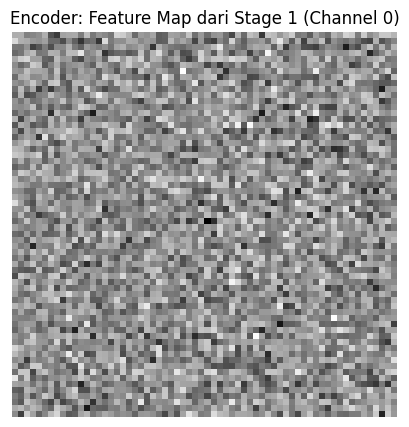

Feature Map Stage 2 Shape: torch.Size([4, 64, 32, 32])


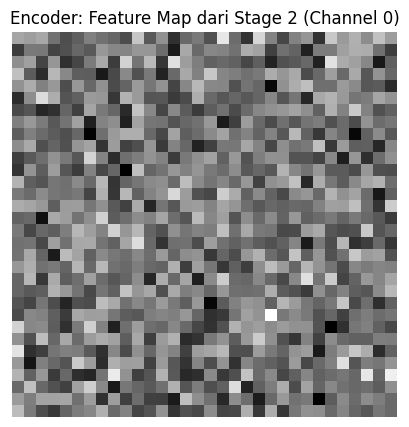

Feature Map Stage 3 Shape: torch.Size([4, 160, 16, 16])


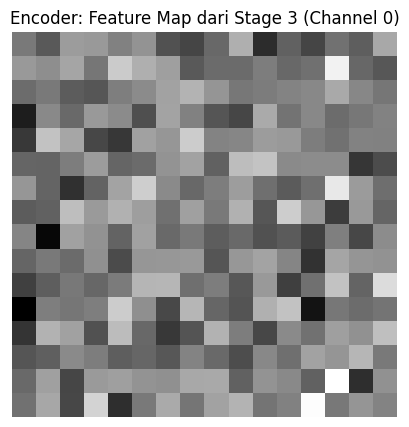

Feature Map Stage 4 Shape: torch.Size([4, 256, 8, 8])


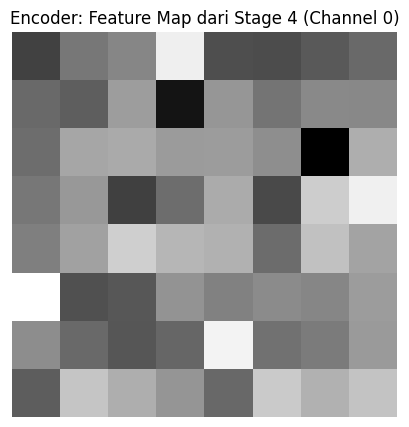

----------------------------------------

--- Decoder (SegFormerDecoder) ---
Shape setelah Upsampling & Proyeksi Linear:
  c1: torch.Size([4, 256, 64, 64]), c2: torch.Size([4, 256, 64, 64]), c3: torch.Size([4, 256, 64, 64]), c4: torch.Size([4, 256, 64, 64])
Shape setelah Concatenate: torch.Size([4, 1024, 64, 64])
Shape sebelum Prediksi Akhir: torch.Size([4, 2, 64, 64])


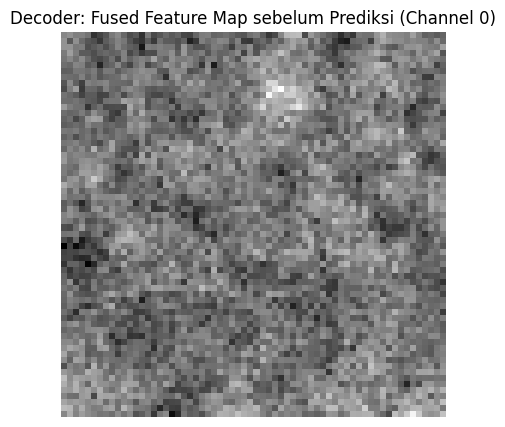


--- Output Akhir Model SegFormer ---
Shape Output Akhir: torch.Size([4, 2, 256, 256])


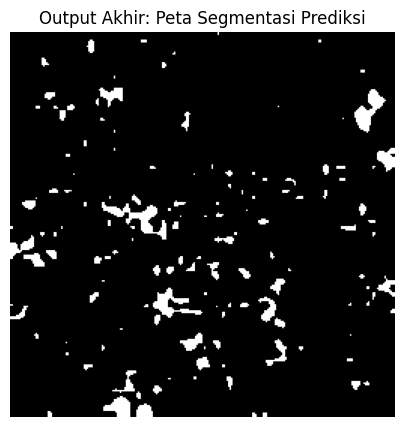

----------------------------------

====== FORWARD PASS SELESAI ======

Shape output akhir yang diterima: torch.Size([4, 2, 256, 256])


In [ ]:
# Inisialisasi model dengan mode verbose=True
print("Membuat model SegFormer dengan verbose=True...")
model = SegFormer(
    num_classes=2,
    variant='B0',
    verbose=True
)

# Buat sebuah tensor input dummy (seperti gambar acak)
dummy_input_image = torch.randn(4, 3, 256, 256) # (Batch=1, Channels=3, Height=256, Width=256)
print(f"Membuat input dummy dengan shape: {dummy_input_image.shape}")

# Lakukan forward pass
print("\n======> MEMULAI FORWARD PASS\n")
model.eval() # Set model ke mode evaluasi
with torch.no_grad(): # Tidak perlu menghitung gradien untuk inferensi
    output = model(dummy_input_image)
print("\n======> FORWARD PASS SELESAI\n")

# Implementation SegFormer

## Dataset Initialization

In [ ]:
# Dataset class yang disesuaikan dengan struktur folder images dan mask
class RiceLeafDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Buat list lengkap path ke file, bukan hanya nama file
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
        # Pastikan file mask ada dan memiliki ekstensi .png
        self.mask_paths = [os.path.join(mask_dir, os.path.splitext(os.path.basename(p))[0] + '.png') for p in self.image_paths]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Buka gambar sebagai array NumPy (format yang disukai Albumentations)
        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L")) # "L" untuk mode grayscale

        # Pastikan label mask sudah benar (0 untuk background, 1 untuk penyakit)
        mask[mask == 38] = 1 # Mapping value 38 to class 1

        if self.transform:
            # Albumentations butuh input dalam bentuk dictionary
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        # Mask harus bertipe LongTensor untuk CrossEntropyLoss
        return image, mask.long()

### Unique Mask Value

In [ ]:
def get_unique_mask_values(mask_dir):
    unique_values = set()
    for mask_file in os.listdir(mask_dir):
        if mask_file.endswith('.png'):
            mask_path = os.path.join(mask_dir, mask_file)
            # Buka gambar ke dalam bentuk grayscale
            with Image.open(mask_path).convert('L') as img:
                # Konversi ke dalam format numpy array dan cari nilai pixel yang unique
                mask_array = np.array(img)
                for value in np.unique(mask_array):
                    unique_values.add(value)
    return sorted(list(unique_values))

print("Unique pixel values in training masks:", get_unique_mask_values(train_mask_dir))
print("Unique pixel values in validation masks:", get_unique_mask_values(val_mask_dir))
print("Unique pixel values in testing masks:", get_unique_mask_values(test_mask_dir))

Unique pixel values in training masks: [np.uint8(0), np.uint8(38)]
Unique pixel values in validation masks: [np.uint8(0), np.uint8(38)]
Unique pixel values in testing masks: [np.uint8(0), np.uint8(38)]


## Dataset Preparation

In [ ]:
# Ukuran piksel data citra
WIDTH = 256
HEIGHT = 256
MEAN_NORM = (0.485, 0.456, 0.406)
STD_NORM = (0.229, 0.224, 0.225)

# Definisikan pipeline augmentasi dan transformasi
# ToTensorV2 akan menangani normalisasi dan konversi ke tensor
transform = A.Compose([
    A.Resize(height=HEIGHT, width=WIDTH),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    A.Normalize(mean=MEAN_NORM, std=STD_NORM),
    ToTensorV2(),
])

train_dataset = RiceLeafDataset(train_img_dir, train_mask_dir, transform=transform)
val_dataset = RiceLeafDataset(val_img_dir, val_mask_dir, transform=transform)

### Sample Data

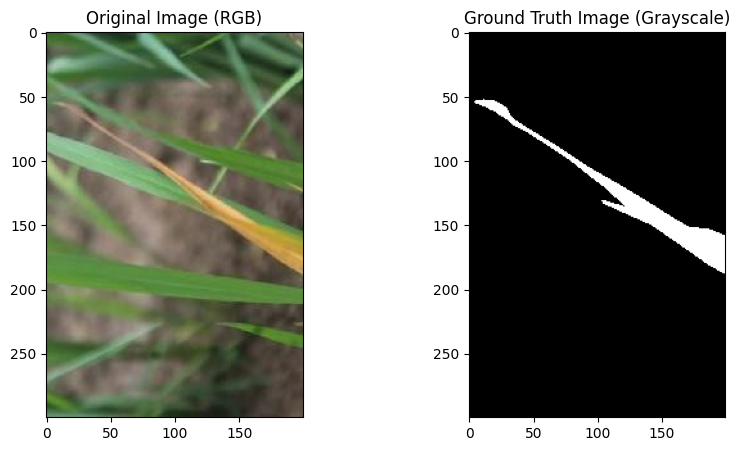

In [ ]:
# Ambil sample dari training dataset
img_path = train_dataset.image_paths[0]
mask_path = train_dataset.mask_paths[0]

# Pastikan file mask ada dan memiliki ekstensi .png
mask_path = mask_path.replace('.jpg', '.png')

# Load data citra asli dengan cv2 and lakukan konversi BGR ke RGB
original_image = cv2.imread(img_path) # cv2 membaca data image BGR secara default
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB) # Konversu ke RGB

# Load data citra mask dengan cv2 dan konversi dalam bentuk grayscale
original_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Visualisai data citra
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(original_image)
ax[0].set_title("Original Image (RGB)")
ax[1].imshow(original_mask, cmap='gray')
ax[1].set_title("Ground Truth Image (Grayscale)")
plt.show()

## Hyperparameter Initialization

In [ ]:
# Inisialisasi hiperparameter
VARIANT = 'B0'
BATCH_SIZE = 1  # B0=4, B3=2, B5=1
LR = 1e-4
TENSOR_WEIGHTS = [0.5, 2.5] # untuk 2 class (0.5 untuk class 0 dan 2.5 untuk class 1)

# Dataloader setup
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Device setup
# device = torch.device('dml' if torch.backends.directml.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Definisi model SegFormer (dari kode sebelumnya, pilih variant)
model = SegFormer(num_classes=2, variant=VARIANT, drop_rate=0.1, verbose=False)
model = model.to(device)

# Loss, optimizer, dan scheduler
class_weights = torch.tensor(TENSOR_WEIGHTS).to(device) # Pindahkan ke GPU jika perlu
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Untuk multi-class (0=bg, 1=foreground)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)  # Weight decay untuk Transformer
scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=1e-6)

Using device: cpu


## Training Model

In [ ]:
# Training loop
NUM_EPOCHS = 25
CHECKPOINT_PATH = 'segformer_checkpoint.pth'
START_EPOCH = 0

# Cek jika terdapat file checkpoint
if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    START_EPOCH = checkpoint['epoch'] + 1
    print(f"Checkpoint ditemukan. Melanjutkan training dari epoch {START_EPOCH + 1}")

# Gunakan range(START_EPOCH, NUM_EPOCHS)
print(f"Training dari epoch {START_EPOCH + 1} hingga {NUM_EPOCHS}")
print(f"-----> Mulai Training")
for epoch in range(START_EPOCH, NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step() # Panggil scheduler setiap iterasi jika T_max = total iterasi

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])

    epoch_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {epoch_loss:.4f}")

    # Simpan checkpoint setiap epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
    }, CHECKPOINT_PATH)

    # Lakukan validasi
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Validation Loss: {val_loss / len(val_loader):.4f}")

print("\n-----> Training selesai!")
# Save model final
torch.save(model.state_dict(), f'segformer_{VARIANT}_final.pth')

Epoch 1/25:   0%|          | 0/1592 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/25: 100%|██████████| 1592/1592 [13:03<00:00,  2.03it/s, loss=0.221, lr=1e-6]

Epoch 1/25, Train Loss: 0.1708


Validation Loss: 0.1790


Epoch 2/25: 100%|██████████| 1592/1592 [13:02<00:00,  2.03it/s, loss=0.0282, lr=0.0001]


Epoch 2/25, Train Loss: 0.1333
Validation Loss: 0.1498


Epoch 3/25: 100%|██████████| 1592/1592 [13:19<00:00,  1.99it/s, loss=0.113, lr=1e-6]

Epoch 3/25, Train Loss: 0.1106


Validation Loss: 0.1295


Epoch 4/25: 100%|██████████| 1592/1592 [13:17<00:00,  2.00it/s, loss=0.593, lr=0.0001]

Epoch 4/25, Train Loss: 0.1009


Validation Loss: 0.1292


Epoch 5/25: 100%|██████████| 1592/1592 [13:15<00:00,  2.00it/s, loss=0.0423, lr=1e-6]

Epoch 5/25, Train Loss: 0.0902


Validation Loss: 0.1076


Epoch 6/25: 100%|██████████| 1592/1592 [13:15<00:00,  2.00it/s, loss=0.0412, lr=0.0001]

Epoch 6/25, Train Loss: 0.0824


Validation Loss: 0.1225


Epoch 7/25: 100%|██████████| 1592/1592 [13:15<00:00,  2.00it/s, loss=0.0191, lr=1e-6]

Epoch 7/25, Train Loss: 0.0785


Validation Loss: 0.1155


Epoch 8/25: 100%|██████████| 1592/1592 [13:11<00:00,  2.01it/s, loss=0.0561, lr=0.0001]


Epoch 8/25, Train Loss: 0.0721
Validation Loss: 0.1124


Epoch 9/25: 100%|██████████| 1592/1592 [13:20<00:00,  1.99it/s, loss=0.0379, lr=1e-6]

Epoch 9/25, Train Loss: 0.0709


Validation Loss: 0.1048


Epoch 10/25: 100%|██████████| 1592/1592 [13:16<00:00,  2.00it/s, loss=0.0847, lr=0.0001]

Epoch 10/25, Train Loss: 0.0652


Validation Loss: 0.1161


Epoch 11/25: 100%|██████████| 1592/1592 [13:19<00:00,  1.99it/s, loss=0.0133, lr=1e-6]

Epoch 11/25, Train Loss: 0.0647


Validation Loss: 0.0959


Epoch 12/25: 100%|██████████| 1592/1592 [13:19<00:00,  1.99it/s, loss=0.0755, lr=0.0001]


Epoch 12/25, Train Loss: 0.0607
Validation Loss: 0.1061


Epoch 13/25: 100%|██████████| 1592/1592 [13:19<00:00,  1.99it/s, loss=0.0347, lr=1e-6]

Epoch 13/25, Train Loss: 0.0595


Validation Loss: 0.1017


Epoch 14/25: 100%|██████████| 1592/1592 [13:13<00:00,  2.01it/s, loss=0.0778, lr=0.0001]

Epoch 14/25, Train Loss: 0.0569


Validation Loss: 0.1067


Epoch 15/25: 100%|██████████| 1592/1592 [13:17<00:00,  2.00it/s, loss=0.018, lr=1e-6]

Epoch 15/25, Train Loss: 0.0551


Validation Loss: 0.0947


Epoch 16/25: 100%|██████████| 1592/1592 [13:15<00:00,  2.00it/s, loss=0.0143, lr=0.0001]

Epoch 16/25, Train Loss: 0.0521


Validation Loss: 0.0972


Epoch 17/25: 100%|██████████| 1592/1592 [13:16<00:00,  2.00it/s, loss=0.018, lr=1e-6]

Epoch 17/25, Train Loss: 0.0523


Validation Loss: 0.0935


Epoch 18/25: 100%|██████████| 1592/1592 [13:17<00:00,  2.00it/s, loss=0.183, lr=0.0001]

Epoch 18/25, Train Loss: 0.0499


Validation Loss: 0.0884


Epoch 19/25: 100%|██████████| 1592/1592 [13:18<00:00,  1.99it/s, loss=0.0077, lr=1e-6]

Epoch 19/25, Train Loss: 0.0497


Validation Loss: 0.0955


Epoch 20/25: 100%|██████████| 1592/1592 [13:13<00:00,  2.01it/s, loss=0.0152, lr=0.0001]


Epoch 20/25, Train Loss: 0.0471
Validation Loss: 0.1192


Epoch 21/25: 100%|██████████| 1592/1592 [13:17<00:00,  2.00it/s, loss=0.0482, lr=1e-6]

Epoch 21/25, Train Loss: 0.0484


Validation Loss: 0.1088


Epoch 22/25: 100%|██████████| 1592/1592 [13:17<00:00,  2.00it/s, loss=0.932, lr=0.0001]

Epoch 22/25, Train Loss: 0.0453


Validation Loss: 0.1124


Epoch 23/25: 100%|██████████| 1592/1592 [13:15<00:00,  2.00it/s, loss=0.0698, lr=1e-6]

Epoch 23/25, Train Loss: 0.0459


Validation Loss: 0.0996


Epoch 24/25: 100%|██████████| 1592/1592 [13:10<00:00,  2.01it/s, loss=0.0271, lr=0.0001]


Epoch 24/25, Train Loss: 0.0430
Validation Loss: 0.1105


Epoch 25/25: 100%|██████████| 1592/1592 [13:09<00:00,  2.02it/s, loss=0.0879, lr=1e-6]


Epoch 25/25, Train Loss: 0.0443
Validation Loss: 0.0995
Training selesai!


## Testing Model

In [ ]:
# Inisialisasi test dataset
test_dataset = RiceLeafDataset(test_img_dir, test_mask_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Evaluasi pada test set
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device, dtype=torch.long)
        outputs = model(images)
        test_loss += criterion(outputs, masks).item()
print(f"Test Loss: {test_loss / len(test_loader)}")

Test Loss: 0.09047398882219568


# Save Model with ONNX

In [ ]:
# Ekspor model ke ONNX
dummy_input = torch.randn(BATCH_SIZE, 3, HEIGHT, WIDTH).to(device)
torch.onnx.export(model, dummy_input, f'segformer_{VARIANT}_final.onnx',
                  export_params=True, opset_version=11,
                  do_constant_folding=True,
                  input_names=['image'], output_names=['output'],
                  dynamic_axes={'image': {0: 'batch_size'}, 'output': {0: 'batch_size'}})
print("Model exported to ONNX!")

/tmp/ipython-input-245931061.py:3: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, dummy_input, "rice_leaf_model.onnx",


Model exported to ONNX!


# Evaluation with MIoU & PA

In [ ]:
# Load model
model = SegFormer(num_classes=2, variant=VARIANT, drop_rate=0.1, verbose=False)
model.load_state_dict(torch.load(f'segformer_{VARIANT}_final.pth'))

# Inisialisasi metrics
metric_iou = MulticlassJaccardIndex(num_classes=2, average='none').to(device)
metric_accuracy = MulticlassAccuracy(num_classes=2, average='none').to(device)

model.eval()
test_loss = 0.0
total_iou = torch.zeros(2).to(device) # Inisialisasi IoU untuk setiap class
total_accuracy = torch.zeros(2).to(device) # Inisialisasi Accuracy untuk setiap class
total_samples = 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device, dtype=torch.long)
        outputs = model(images)
        test_loss += criterion(outputs, masks).item()

        # Prediksi menggunakan argmax daro dimensi class
        preds = torch.argmax(outputs, dim=1)

        # Update metrics
        total_iou += metric_iou(preds, masks) * masks.size(0) # Kalikan dengan batch size untuk proses sum
        total_accuracy += metric_accuracy(preds, masks) * masks.size(0)
        total_samples += masks.size(0)

# Rata-rata metrics
avg_iou = total_iou / total_samples
avg_accuracy = total_accuracy / total_samples

print(f"Test Loss: {test_loss / len(test_loader)}")
print(f"MIoU (Mean IoU): {avg_iou.mean().item()}")
print(f"IoU per class: {avg_iou.tolist()}")
print(f"Pixel Accuracy (Mean Accuracy): {avg_accuracy.mean().item()}")
print(f"Accuracy per class: {avg_accuracy.tolist()}")

Test Loss: 0.09047398882219568
MIoU (Mean IoU): 0.8332403302192688
IoU per class: [0.9794032573699951, 0.6870774030685425]
Pixel Accuracy (Mean Accuracy): 0.925708532333374
Accuracy per class: [0.9838934540748596, 0.8675235509872437]


# Visualize Model Result

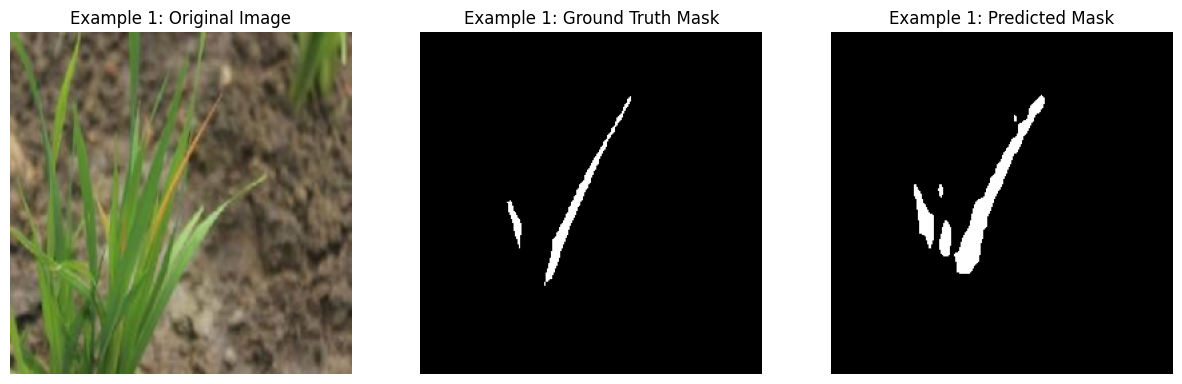

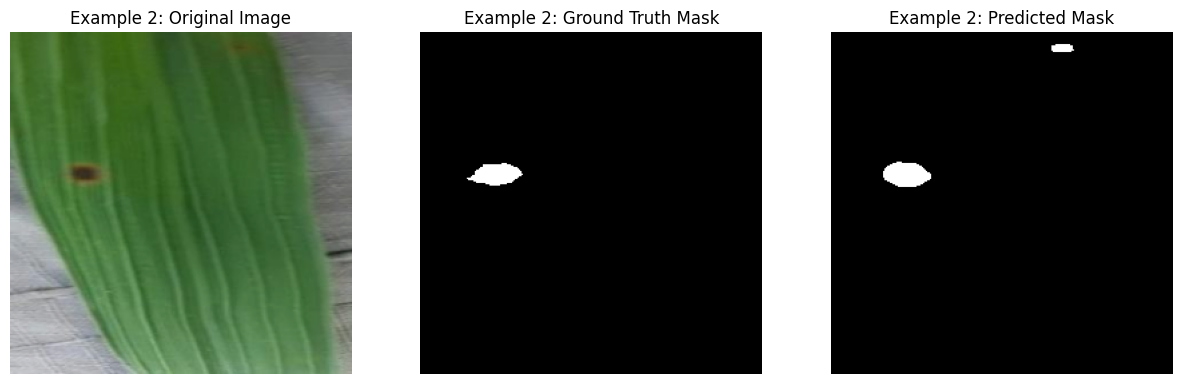

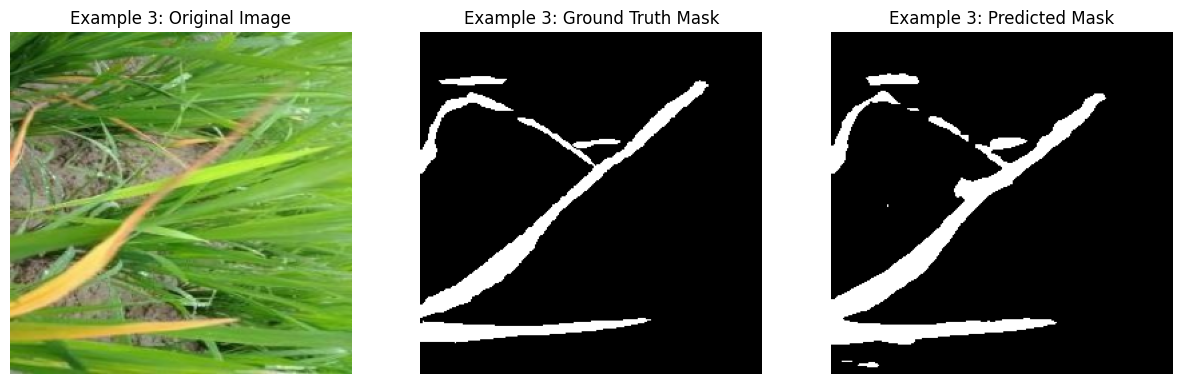

In [ ]:
# Ambil beberapa sample dari test dataset
num_examples_to_show = 3

for i in range(num_examples_to_show):
    image, mask = test_dataset[i]

    # Tambahkan dimensi batch ke dalam device
    image_input = image.unsqueeze(0).to(device)

    # Lakukan prediksi model
    model.eval()
    with torch.no_grad():
        output = model(image_input)

    # Hasil prediksi mask
    predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu()

    # Konversi tensors kembali ke bentuk PIL Images (mengembalikan normalisasi) untuk visualisasi
    mean = torch.tensor((0.485, 0.456, 0.406)).view(3, 1, 1)
    std = torch.tensor((0.229, 0.224, 0.225)).view(3, 1, 1)
    image_display = image.squeeze(0).cpu() * std + mean
    image_display = TF.to_pil_image(image_display)

    # Buat binary masks (white foreground, black background)
    # Atur semua non-zero values pada Ground Truth Mask ke 255 (putih: daerah yang terkena penyakit)
    mask_display = mask.byte().numpy()
    mask_display[mask_display > 0] = 255
    mask_display = Image.fromarray(mask_display)

    # Atur juga semua non-zero values pada Predicted Mask ke 255 (putih: daerah yang terkena penyakit)
    predicted_mask_display = predicted_mask.byte().numpy()
    predicted_mask_display[predicted_mask_display > 0] = 255
    predicted_mask_display = Image.fromarray(predicted_mask_display)

    # Plot the images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image_display)
    ax[0].set_title(f"Example {i+1}: Original Image")
    ax[0].axis('off')

    ax[1].imshow(mask_display, cmap='gray')
    ax[1].set_title(f"Example {i+1}: Ground Truth Mask")
    ax[1].axis('off')

    ax[2].imshow(predicted_mask_display, cmap='gray')
    ax[2].set_title(f"Example {i+1}: Predicted Mask")
    ax[2].axis('off')

    plt.show()